In [1]:
import os

# os.environ['LD_LIBRARY_PATH'] = os.environ.get('LD_LIBRARY_PATH', '') + ':/home/drhead/miniconda3/envs/sam_hq_xla/lib:/usr/local/cuda/targets/x86_64-linux/lib'
os.environ['PT_XLA_DEBUG'] = '1' 
os.environ['PT_XLA_DEBUG_FILE'] = './xla_debug.txt'
os.environ['PJRT_DEVICE'] = 'TPU'

# Nonzero op lowering is unstable but seems to work for some ops
# os.environ['XLA_EXPERIMENTAL'] = 'nonzero'

# Will cast torch.float and torch.double to BF16
# os.environ['XLA_USE_BF16'] = '1'

# Will cast torch.float to BF16 and torch.double to float32
# os.environ['XLA_DOWNCAST_BF16'] = '1'

import numpy as np
import torch
print("PyTorch version:", torch.__version__)
import torch_xla.core.xla_model as xm

if xm.get_xla_supported_devices("GPU") is not None:
    print("XLA GPU is available")
elif xm.get_xla_supported_devices("TPU") is not None:
    print("XLA TPU is available:", xm.get_xla_supported_devices("TPU",8))

import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.optim as optim
import torch.distributed as dist
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_backend
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.experimental.pjrt_backend
import torch_xla.experimental.pjrt as pjrt
import matplotlib.pyplot as plt
import cv2
import time

import torch_xla.debug.profiler as xp
import torch_xla.utils.utils as xu
import multiprocessing


# !git clone -b xla https://github.com/drhead/sam-hq.git
# os.chdir('sam-hq')
# !export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


PyTorch version: 2.0.0a0+gitc263bd4
XLA TPU is available: ['xla:0', 'xla:1', 'xla:2', 'xla:3', 'xla:4', 'xla:5', 'xla:6', 'xla:7']


In [2]:
#!mkdir pretrained_checkpoint
#!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
#!mv sam_hq_vit_l.pth pretrained_checkpoint


In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation'].cpu()
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

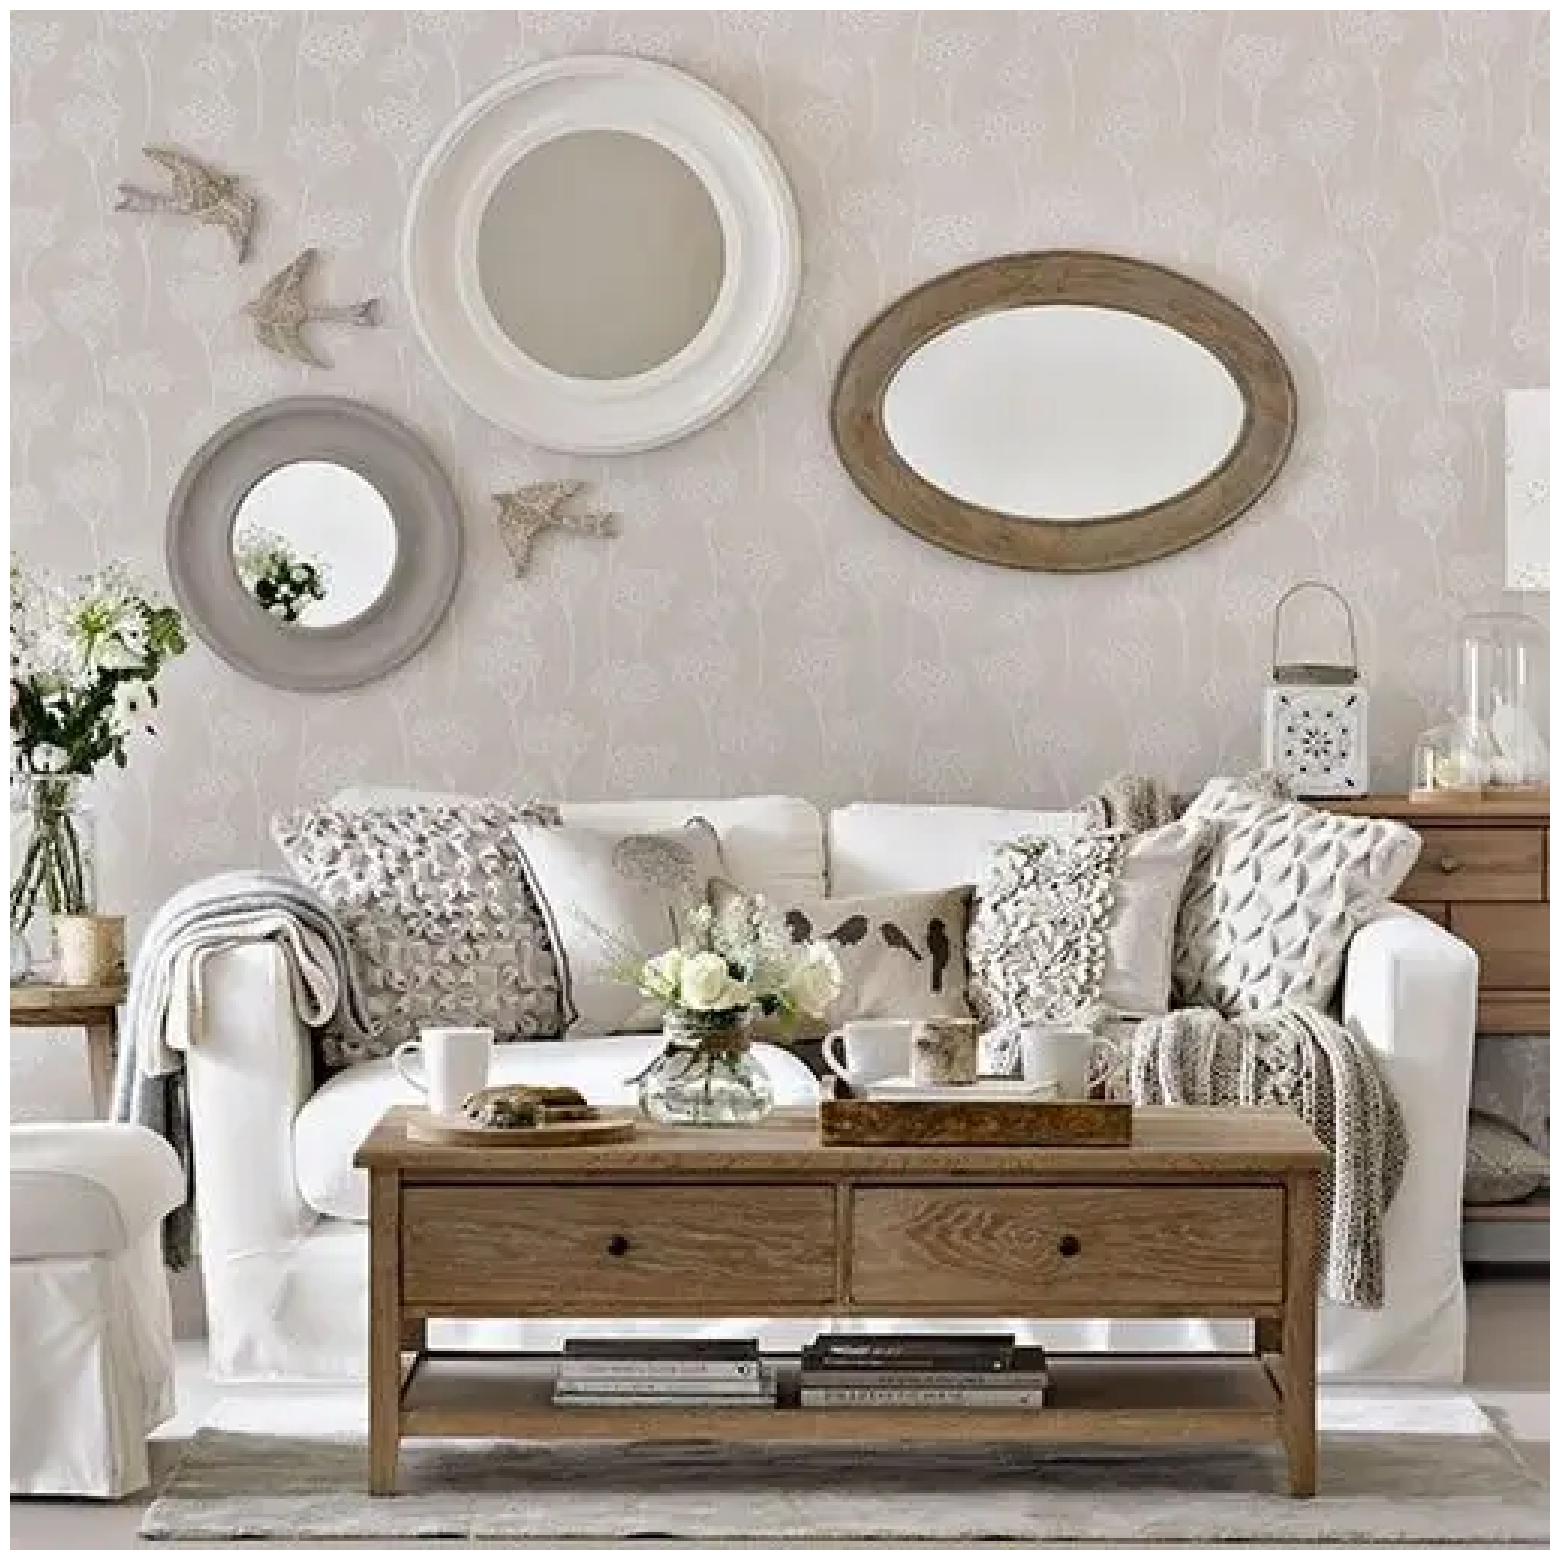

In [4]:
image = cv2.imread('data/zd_testimgs/-663378304158021540.webp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
dist.init_process_group('xla', init_method='pjrt://')

sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
model_type = "vit_l"
device = xm.xla_device()
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

sam.eval()
sam_dynamo = torch.compile(sam, backend='torchxla_trace_once')

mask_generator = SamAutomaticMaskGenerator(
    model=sam_dynamo,
    points_per_side=8,
    points_per_batch=64,
    min_mask_region_area=0,  # Requires open-cv to run post-processing
)

<All keys matched successfully>


In [9]:
def gen_masks():
    xp.trace('localhost:6009', logdir='/home/lodestone/sam-hq/', num_tracing_attempts=1, timeout_s=15, duration_ms=90000)
    print('Done tracing')

p = multiprocessing.Process(target=gen_masks)
p.start()
server = xp.start_server(6009)
time.sleep(10)
with xp.StepTrace('gen_steps',step_num=0):
    with xp.Trace('generate'):
        masks = mask_generator.generate(image, multimask_output=False)
        print(len(masks))
with xp.StepTrace('gen_steps',step_num=1):
    with xp.Trace('generate'):
        masks = mask_generator.generate(image, multimask_output=False)
        print(len(masks))
with xp.StepTrace('gen_steps',step_num=2):
    with xp.Trace('generate'):
        masks = mask_generator.generate(image, multimask_output=False)
        print(len(masks))
with xp.StepTrace('gen_steps',step_num=3):
    with xp.Trace('generate'):
        masks = mask_generator.generate(image, multimask_output=False)
        print(len(masks))

p.join()

12
12
12
12


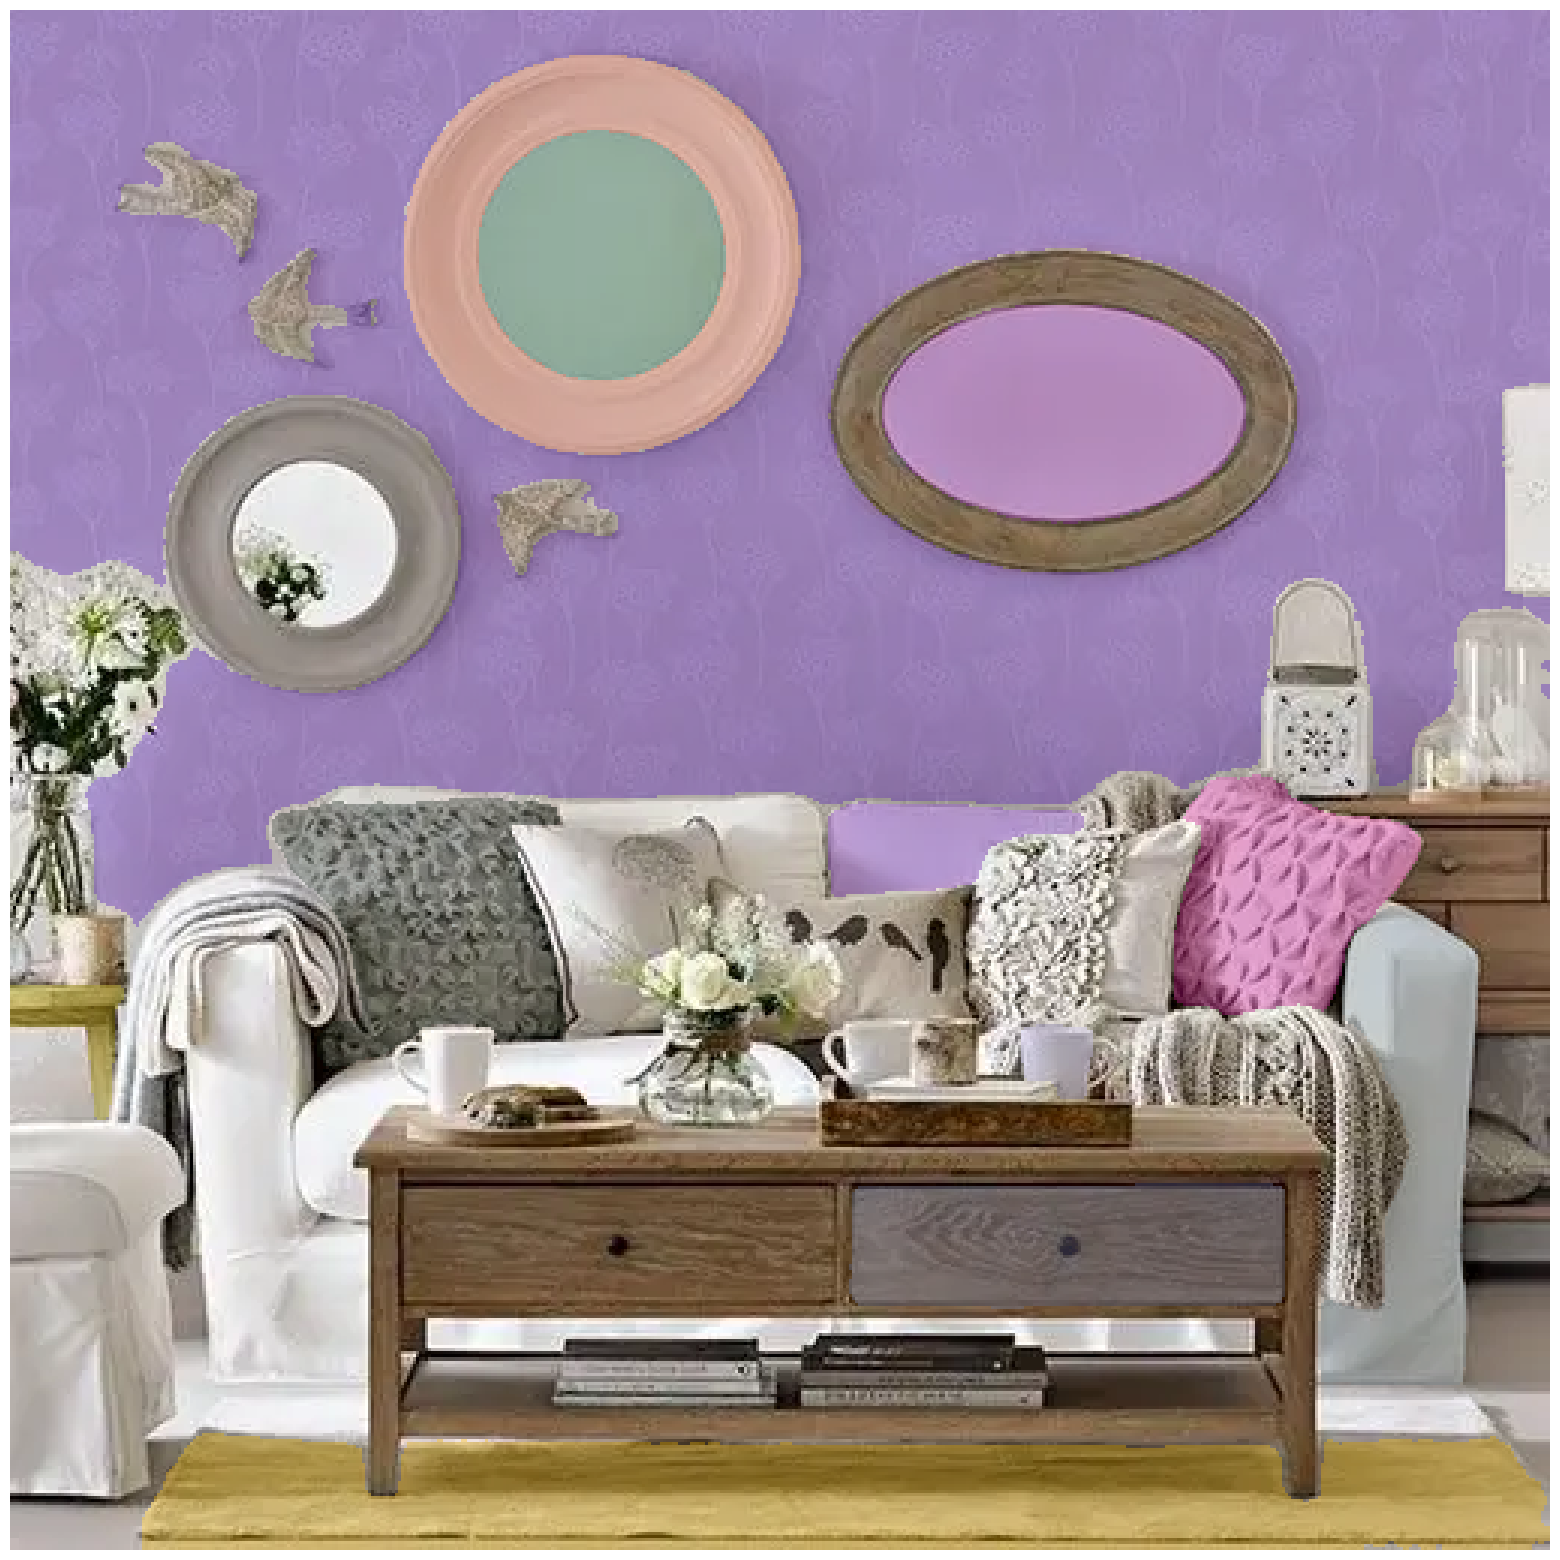

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [8]:
import torch_xla.debug.metrics as met
print(met.metrics_report())
met.clear_all()

Metric: DeviceLockWait
  TotalSamples: 910
  Accumulator: 004ms730.950us
  ValueRate: 006.556us / second
  Rate: 1.5991 / second
  Percentiles: 1%=000.899us; 5%=000.951us; 10%=000.982us; 20%=001.026us; 50%=004.704us; 80%=005.523us; 90%=008.180us; 95%=010.940us; 99%=026.183us
Metric: InputOutputAliasCount
  TotalSamples: 2
  Accumulator: 509.00
  ValueRate: 11.34 / second
  Rate: 0.0445387 / second
  Percentiles: 1%=0.00; 5%=0.00; 10%=0.00; 20%=0.00; 50%=509.00; 80%=509.00; 90%=509.00; 95%=509.00; 99%=509.00
Metric: IrValueTensorToXlaData
  TotalSamples: 777
  Accumulator: 613ms663.240us
  ValueRate: 001ms106.896us / second
  Rate: 1.4038 / second
  Percentiles: 1%=020.896us; 5%=026.921us; 10%=029.452us; 20%=035.341us; 50%=058.596us; 80%=134.947us; 90%=001ms256.376us; 95%=003ms210.522us; 99%=014ms245.821us
Metric: TensorToData
  TotalSamples: 809
  Accumulator: 612ms255.060us
  ValueRate: 001ms106.158us / second
  Rate: 1.46162 / second
  Percentiles: 1%=019.541us; 5%=025.786us; 10%=028